In [1]:
from tsl.data.spatiotemporal_dataset import SpatioTemporalDataset
from tsl.ops.connectivity import edge_index_to_adj
import pandas as pd 
import numpy as np


In [2]:
target = pd.read_csv("../data/eaglei_data/eaglei_outages_2022.csv")

In [3]:
adj = pd.read_csv("../data/geographic/graph.csv")
# sum all edges per county
adj = adj.groupby(["src", "dest"])["total_voltage"].sum().reset_index()

In [4]:
# get all unique counties
unique = pd.unique(np.concat((target["fips_code"].values.ravel(), adj[["src","dest"]].values.ravel())))
fips2idx = pd.Series(index=unique, data=range(len(unique)))
fips2idx

1005        0
1009        1
1051        2
1055        3
1057        4
         ... 
72081    3181
72141    3182
72147    3183
72049    3184
72151    3185
Length: 3186, dtype: int64

In [5]:
numeric_times = False
target_mapped = target.copy()

### Map fips code to idx
target_mapped["fips_code"] = target["fips_code"].map(fips2idx).astype(np.int64)
### Convert time to int

target_mapped = target_mapped[["fips_code","customers_out","run_start_time"]]
if numeric_times:
    target_mapped.loc[:, "slot"] = pd.to_datetime(target_mapped["run_start_time"]).dt.floor("15min")

    unique_times = target_mapped["slot"].drop_duplicates().sort_values().reset_index(drop=True)

    slot2int = pd.Series(data=range(len(unique_times)), index=unique_times)
    target_mapped.loc[:,"run_start_time"] = target_mapped["slot"].map(slot2int)
    target_mapped["run_start_time"] = pd.to_numeric(target_mapped["run_start_time"], 'raise')
else:
    target_mapped["run_start_time"] = pd.to_datetime(target_mapped["run_start_time"], 'raise')
    
target_mapped = target_mapped[["fips_code","customers_out","run_start_time"]].pivot(index="run_start_time", columns="fips_code", values="customers_out")
target_mapped.fillna(0,inplace=True)
target_mapped

fips_code,0,1,2,3,4,5,6,7,8,9,...,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056
run_start_time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,4.0,160.0,3.0,4.0,4.0,4.0,61.0,15.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 00:15:00,4.0,160.0,3.0,4.0,0.0,4.0,97.0,15.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 00:30:00,4.0,160.0,0.0,4.0,0.0,4.0,96.0,15.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 00:45:00,4.0,801.0,0.0,4.0,0.0,4.0,96.0,14.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 01:00:00,4.0,249.0,0.0,4.0,0.0,4.0,96.0,14.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:45:00,0.0,0.0,4.0,7.0,0.0,0.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 23:00:00,0.0,0.0,5.0,7.0,0.0,0.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 23:15:00,0.0,0.0,5.0,7.0,0.0,0.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
missing_cols = set(target_mapped.columns.to_numpy()).symmetric_difference(set(range(len(unique))))
new_cols = [target_mapped]
for id in missing_cols:
    new_cols.append(pd.Series([0.0]*len(target_mapped),index=target_mapped.index, name=id))
target_mapped = pd.concat(new_cols, axis=1)

In [7]:
adj_mapped = adj.copy()
adj_mapped["src"] = adj["src"].map(fips2idx)
adj_mapped["dest"] = adj["dest"].map(fips2idx)
adj_mapped
# adj_mapped.convert_dtypes()

,src,dest,total_voltage
0,1326,1690,500.000000
1,1326,695,126.976994
2,1326,696,575.000000
3,1326,2,460.000000
4,1326,1593,230.000000
...,...,...,...
7102,3182,3181,126.976994
7103,3183,3184,38.000000
7104,3183,3160,38.000000
7105,3185,3153,230.000000


In [8]:
adj_mat = edge_index_to_adj(adj_mapped[["src","dest"]].values.T, adj_mapped["total_voltage"].values, len(fips2idx))


In [9]:
adj_mat

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 38.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(3186, 3186))

In [10]:
import xarray
with open("../data/dataset_source-era5_date-2022-01-01_res-1.0_levels-37_steps-40.nc", "rb") as f:
    example = xarray.load_dataset(f).compute()

/var/folders/64/2wpm0m9j5rz5163pjzwk435m0000gn/T/ipykernel_51019/3569955375.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  example = xarray.load_dataset(f).compute()


In [11]:
example

<xarray.Dataset> Size: 2GB
Dimensions:                       (lon: 360, lat: 181, time: 42, level: 37,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 1kB 0.0 1.0 2.0 ... 358.0 359.0
  * lat                           (lat) float32 724B -90.0 -89.0 ... 89.0 90.0
  * time                          (time) timedelta64[ns] 336B 0 days 00:00:00...
  * level                         (level) int32 148B 1 2 3 5 ... 950 975 1000
    datetime                      (batch, time) datetime64[ns] 336B 2022-01-0...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 261kB 2.735e+04 ... -0.0...
    land_sea_mask                 (lat, lon) float32 261kB 1.0 1.0 ... 0.0 0.0
    2m_temperature                (batch, time, lat, lon) float32 11MB 250.7 ...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 11MB 9.931e...
    10m_v_component_of_wind       (batch, time, lat, lon) float32 11MB -0.439...
    10m_u_component_of_wind       (batch, time, lat, lon) float32 11MB 1.309 ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 405MB ...
    geopotential                  (batch, time, level, lat, lon) float32 405MB ...
    u_component_of_wind           (batch, time, level, lat, lon) float32 405MB ...
    v_component_of_wind           (batch, time, level, lat, lon) float32 405MB ...
    vertical_velocity             (batch, time, level, lat, lon) float32 405MB ...
    specific_humidity             (batch, time, level, lat, lon) float32 405MB ...

In [12]:
from src.utils.id_powerline_endpoints import load_counties
import geopandas as gpd
from shapely import Point

# example.apply(lambda row: Point(row['lon'], row['lat']))
df = example.to_dataframe()

In [13]:
# # Get the MultiIndex as a DataFrame
# index_df = 

# Get unique (lon, lat) pairs

lon_lat_df = df.index.to_frame(index=False)[['lon', 'lat']].drop_duplicates()
lon_lat_df['lon_fixed'] = lon_lat_df['lon'].apply(lambda x: x - 360 if x > 180 else x)
lon_lat_df['geometry'] = lon_lat_df.apply(lambda row: Point(row['lon_fixed'], row['lat']), axis=1)


<Axes: >

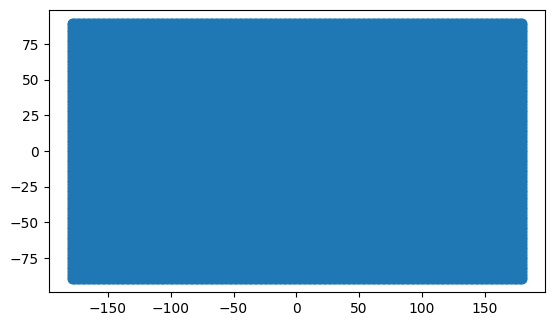

In [ ]:
gdf_points = gpd.GeoDataFrame(lon_lat_df, geometry='geometry',crs='EPSG:4326' )
counties = load_counties().to_crs('EPSG:4326')
ax = gdf_points["geometry"].plot()
counties.plot(ax=ax)    

# import matplotlib.pyplot as plt 


In [15]:

joined = gpd.sjoin(gdf_points, counties[['GEOID', 'geometry']], how='left', predicate='within')
lon_lat_to_geoid = joined.set_index(['lon', 'lat'])['GEOID']
df_index = df.index.to_frame()

# Map each (lon, lat) to GEOID
df_index['county_geoid'] = df_index.set_index(['lon', 'lat']).index.map(lon_lat_to_geoid)

# Replace the index of df with df_index (or merge back, depending on how you want to keep structure)

(10.0, 75.0)

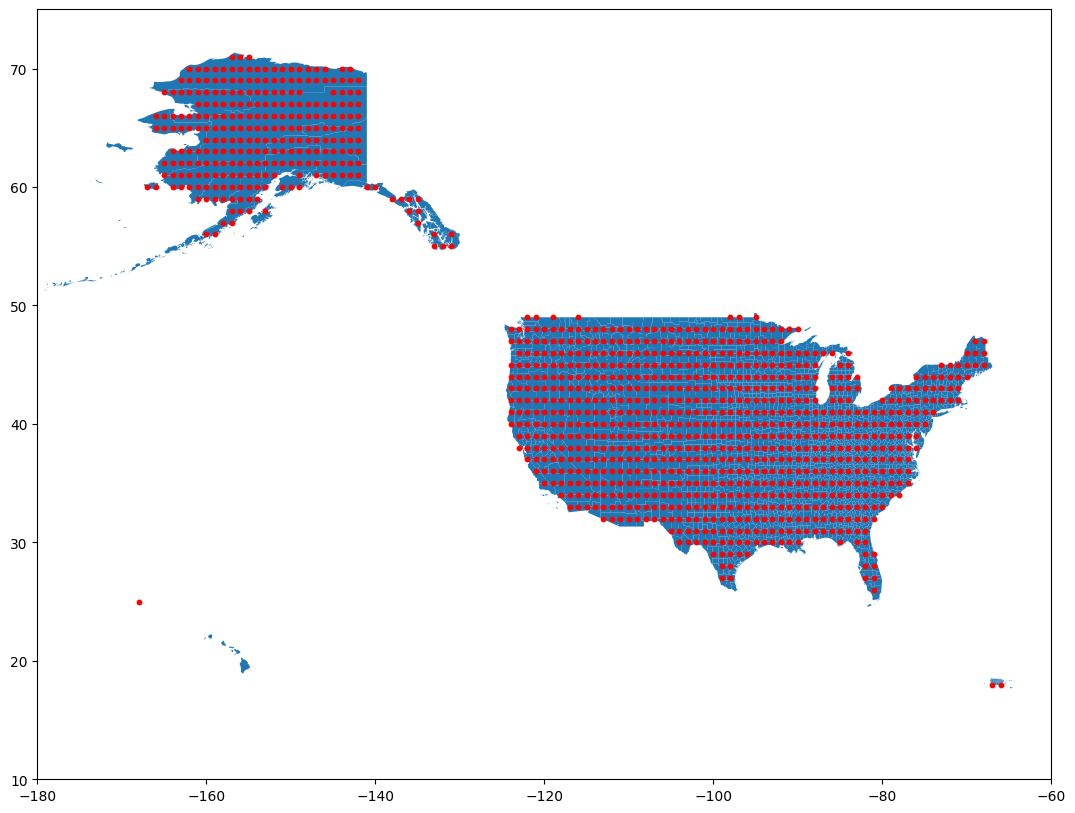

In [16]:
ax = counties.plot()
joined[~joined["GEOID"].isna()].plot(ax=ax, markersize=10, c="red")
ax.figure.set_size_inches(100,10)

ax.set_xlim(-180,-60)
ax.set_ylim(10,75)

In [17]:
df.columns

Index(['geopotential_at_surface', 'land_sea_mask', '2m_temperature',
       'mean_sea_level_pressure', '10m_v_component_of_wind',
       '10m_u_component_of_wind', 'total_precipitation_6hr',
       'toa_incident_solar_radiation', 'temperature', 'geopotential',
       'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity',
       'specific_humidity', 'datetime'],
      dtype='object')

In [19]:
df.reset_index().set_index([
    'lon', 'lat', 'datetime', 'level', 
]).drop(columns=["batch","time"])

geopotential_at_surface  land_sea_mask  \
lon   lat   datetime            level                                           
0.0   -90.0 2022-01-01 00:00:00 1                 27354.750000            1.0   
                                2                 27354.750000            1.0   
                                3                 27354.750000            1.0   
                                5                 27354.750000            1.0   
                                7                 27354.750000            1.0   
...                                                        ...            ...   
359.0  90.0 2022-01-11 06:00:00 900                  -0.076172            0.0   
                                925                  -0.076172            0.0   
                                950                  -0.076172            0.0   
                                975                  -0.076172            0.0   
                                1000                 -0.076172            0.0   

                                       2m_temperature  \
lon   lat   datetime            level                   
0.0   -90.0 2022-01-01 00:00:00 1          250.748978   
                                2          250.748978   
                                3          250.748978   
                                5          250.748978   
                                7          250.748978   
...                                               ...   
359.0  90.0 2022-01-11 06:00:00 900        246.956009   
                                925        246.956009   
                                950        246.956009   
                                975        246.956009   
                                1000       246.956009   

                                       mean_sea_level_pressure  \
lon   lat   datetime            level                            
0.0   -90.0 2022-01-01 00:00:00 1                   99314.2500   
                                2                   99314.2500   
                                3                   99314.2500   
                                5                   99314.2500   
                                7                   99314.2500   
...                                                        ...   
359.0  90.0 2022-01-11 06:00:00 900                100808.0625   
                                925                100808.0625   
                                950                100808.0625   
                                975                100808.0625   
                                1000               100808.0625   

                                       10m_v_component_of_wind  \
lon   lat   datetime            level                            
0.0   -90.0 2022-01-01 00:00:00 1                    -0.439256   
                                2                    -0.439256   
                                3                    -0.439256   
                                5                    -0.439256   
                                7                    -0.439256   
...                                                        ...   
359.0  90.0 2022-01-11 06:00:00 900                   0.154994   
                                925                   0.154994   
                                950                   0.154994   
                                975                   0.154994   
                                1000                  0.154994   

                                       10m_u_component_of_wind  \
lon   lat   datetime            level                            
0.0   -90.0 2022-01-01 00:00:00 1                     1.309354   
                                2                     1.309354   
                                3                     1.309354   
                                5                     1.309354   
                                7                     1.309354   
...                                                        ... 

In [20]:
df["datetime"].max()

Timestamp('2022-01-11 06:00:00')

In [ ]:
from scipy.spatial import cKDTree
import numpy as np
# Ensure df has a MultiIndex with levels ['lon', 'lat', 'time', 'level', 'batch']
df_index = df.index.to_frame(index=False)

# Map each (lon, lat) to GEOID
lon_lat_to_geoid = joined.set_index(['lon', 'lat'])['GEOID']
df_index['county_geoid'] = df_index[['lon', 'lat']].apply(
    lambda row: lon_lat_to_geoid.get((row['lon'], row['lat']), np.nan), axis=1
)

# Step 1: Compute county centroids
county_centroids = counties.geometry.centroid
counties['centroid'] = county_centroids

# Step 2: Extract latitude and longitude of centroids
centroid_coords = np.array([[point.x, point.y] for point in county_centroids])

# Step 3: Build a KDTree for nearest neighbor search
lon_lat_coords = lon_lat_df[['lon_fixed', 'lat']].to_numpy()
tree = cKDTree(lon_lat_coords)
# df.columns = Index(['geopotential_at_surface', 'land_sea_mask', '2m_temperature',
    #    'mean_sea_level_pressure', '10m_v_component_of_wind',
    #    '10m_u_component_of_wind', 'total_precipitation_6hr',
    #    'toa_incident_solar_radiation', 'temperature', 'geopotential',
    #    'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity',
    #    'specific_humidity', 'datetime'],
    #   dtype='object')
# df.index = MultiIndex([(  0.0, -90.0,  '0 days 00:00:00',    1, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',    2, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',    3, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',    5, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',    7, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',   10, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',   20, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',   30, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',   50, 0),
        #     (  0.0, -90.0,  '0 days 00:00:00',   70, 0),
        #     ...
        #     (359.0,  90.0, '10 days 06:00:00',  775, 0),
        #     (359.0,  90.0, '10 days 06:00:00',  800, 0),
        #     (359.0,  90.0, '10 days 06:00:00',  825, 0),
        #     (359.0,  90.0, '10 days 06:00:00',  850, 0),
        #     (359.0,  90.0, '10 days 06:00:00',  875, 0),
        #     (359.0,  90.0, '10 days 06:00:00',  900, 0),
        #     (359.0,  90.0, '10 days 06:00:00',  925, 0),
        #     (359.0,  90.0, '10 days 06:00:00',  950, 0),
        #     (359.0,  90.0, '10 days 06:00:00',  975, 0),
        #     (359.0,  90.0, '10 days 06:00:00', 1000, 0)],
        #    names=['lon', 'lat', 'time', 'level', 'batch'], length=101258640)
# Find the 4 nearest neighbors for each centroid
# Find the 4 nearest neighbors for each centroid
distances, indices = tree.query(centroid_coords, k=4)


/var/folders/64/2wpm0m9j5rz5163pjzwk435m0000gn/T/ipykernel_35423/446507512.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county_centroids = counties.geometry.centroid


In [ ]:
import tqdm
# Perform bilinear interpolation with proper handling of MultiIndex
county_data_list = []
keep  =['geopotential_at_surface', 'land_sea_mask', '2m_temperature',
       'mean_sea_level_pressure', '10m_v_component_of_wind',
       '10m_u_component_of_wind', 'total_precipitation_6hr',
       'toa_incident_solar_radiation', 'temperature', 'geopotential',
       'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity',
       'specific_humidity']
for i, (dists, nbr_idxs) in tqdm.tqdm(enumerate(zip(distances, indices)), total=len(distances)):
    county_id = counties.iloc[i]['GEOID']
    
    # Compute weights for the 4 neighbors
    weights = 1 / (dists + 1e-6)
    weights /= weights.sum()
    
    # Extract weather data for the 4 neighbors
    nbr_dfs = []
    for j in range(4):
        coord = lon_lat_df.iloc[nbr_idxs[j]]
        lon_val, lat_val = coord['lon'], coord['lat']
        try:
            nbr_df = df.xs((lon_val, lat_val), level=['lon', 'lat'])
        except KeyError:
            print("KeyError: ", lon_val, lat_val)
            # Handle missing data by creating a dummy DataFrame
            dummy_index = df.index.levels[2]  # Assuming 'time' is the 3rd level
            nbr_df = pd.DataFrame(np.nan, index=dummy_index, columns=df.columns)
        nbr_dfs.append(nbr_df)
    
    # Weighted sum for bilinear interpolation
    interp_df = nbr_dfs[0][keep] * weights[0]
    # print(interp_df)
    for w, nbr in zip(weights[1:], nbr_dfs[1:]):
        interp_df += nbr[keep] * w
    
    # Add county information and reset index
    interp_df = interp_df.reset_index()
    interp_df['county'] = county_id
    interp_df.set_index(['county', 'datetime', 'level', 'batch'], inplace=True)
    # print(interp_df)
    county_data_list.append(interp_df)


3233it [29:05,  1.85it/s]


In [52]:

# Concatenate all county DataFrames
interpolated_df = pd.concat(county_data_list)
interpolated_df.to_parquet("../data/county_data",compression="gzip", engine="pyarrow", index=True, partition_cols=["county"])

counties.geom -> county centroids -> (lat, long) -> 4 nearest neighbors -> bilinear interpolation 


* Learnable County Embeddings
* Single encoder for weather data (linear layer that takes a vector of weather data and returns a latent vector)
* GNN - Dynamic or static, GAT or GCNN, (Needs to be recurrent model) 
* Decode each county node embedding into a prediction
* Objective - we want to minimize RMSE for 12 hr ahead prediction 


Dynamic vs Static 
GAT vs GCNN 
Transformer Encoder vs FFN Encoder 

f(G) = e 

G - weather- No county info
F- encoder 
e - embedding 

C - Learnable embedding county - Interpretable


Output = f(G) + C  -> GNN input for a given county 

learn one f for all counties 
learn a county specific bias 

Output = f_c(G)
learn a county specific f and bias 

Output = f(G_c)
f must learn to differentiate counties 


In [54]:
len(lon_lat_to_geoid) - lon_lat_to_geoid.isna().sum()

np.int64(1086)

In [63]:
incounties = df_index[~df_index["county_geoid"].isna()]

In [ ]:
SpatioTemporalDataset(target_mapped.resample("6h").median(), covariates=interpolated_df,connectivity=adj_mat)


TypeError: Invalid type for value "<class 'pandas.core.series.Series'>"

In [55]:
for name, value in interpolated_df.items():
    print(value)
    k = input()
    if k == "n":
        break

county  time              level  batch
21007   0 days 00:00:00   1      0        1115.485107
                          2      0        1115.485107
                          3      0        1115.485107
                          5      0        1115.485107
                          7      0        1115.485107
                                             ...     
26139   10 days 06:00:00  900    0        2035.402222
                          925    0        2035.402222
                          950    0        2035.402222
                          975    0        2035.402222
                          1000   0        2035.402222
Name: geopotential_at_surface, Length: 5024082, dtype: float32
